<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<span>
<h2>Eliminación de ruido en imagenes de resonancia magnetica, mediante red neuronal convolucional CNN </h2> 
</span>

<p>
El modelo VGG16 fue el modelo que gano la competicion de clasificacion de imagenes en 2014, en la ImageNet competition. VGG16 es un modelo de red neuronal convolucional propuesto por K. Simonyan y A. Zisserman de la Universidad de Oxford en el artículo "Redes convolucionales muy profundas para el reconocimiento de imágenes a gran escala".El modelo logra una precisión de prueba del 92,7% entre los 5 primeros en ImageNet,que es un conjunto de datos de más de 14 millones de imágenes pertenecientes a 1000 clases. Fue uno de los modelos famosos presentados a ILSVRC-2014 . Realiza la mejora con respecto a AlexNet al reemplazar filtros grandes del tamaño del kernel (11 y 5 en la primera y segunda capa convolucional, respectivamente) con múltiples filtros del tamaño del kernel 3×3 uno tras otro. VGG16 fue entrenado durante semanas y estaba usando GPU NVIDIA Titan Black.</p>

Desafortunadamente, hay dos grandes inconvenientes con VGGNet:
Es  dolorosamente lento  entrenar.
Los pesos de la arquitectura de red en sí mismos son bastante grandes (con respecto al disco/ancho de banda).

https://neurohive.io/en/popular-networks/vgg16/

## Instalar librerías

In [ ]:
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

In [ ]:
!pip install tf-nightly

In [ ]:
!pip install h5py

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install tensorflow-directml

In [ ]:
!pip install matplotlib

In [ ]:
!pip install opencv-python

In [ ]:
!pip install pillow

In [1]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

## Importar librerías

In [45]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import glob
import matplotlib.pyplot as plt
import cv2
import datetime
import time
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras import Model, optimizers

## Configurar GPU con TensorFlow

In [4]:
tensorflow.test.is_gpu_available()
print("Num GPUs available", len(tensorflow.config.experimental.list_physical_devices('GPU')))

print(tensorflow.test.gpu_device_name())
print(tensorflow.test.is_gpu_available())

Num GPUs available 0
/device:DML:0
True


## Preparacion de imagenes

### Definir conjuntos de datos

#### Definir variables de entrenamiento, validacion y prueba

In [3]:
import glob

def read_jpg_files(root_dir):

    files = []
    for filename in glob.iglob(root_dir + '**/*.jpg', recursive=True):
        files.append(filename)
    images = [cv2.imread(file) for file in files]  
    return images

In [4]:
# Entrenamiento
path_train = 'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/ENTRENAMIENTO/' 

# Validacion
path_val = 'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/VALIDACION/' 

# Pruebas
path_test = r'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/PRUEBA/'

### Definir conjuntos de datos en formato KERAS

In [5]:
print(tensorflow.keras.applications.vgg16.VGG16 is tensorflow.keras.applications.VGG16)

True


In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
print(tensorflow.keras.applications.vgg16.VGG16 is VGG16)

True


In [7]:
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

In [57]:
# Generacion de lotes de datos para modelo en Keras en formato vgg16

# Entrenamiento
train_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=path_train, target_size=(224,224), classes=['AD','CN','MCI'], batch_size=10)

# Validacion
valid_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=path_val, target_size=(224,224), classes=['AD','CN','MCI'], batch_size=10)

# Pruebas
test_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=path_test, target_size=(224,224), classes=['AD','CN','MCI'], batch_size=10, shuffle=False)

Found 5343 images belonging to 3 classes.
Found 1265 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


In [9]:
assert train_batches.n == 5343 
assert valid_batches.n == 1265
assert test_batches.n == 63
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3 

In [10]:
imgs, labels = next(train_batches)

In [11]:
"""Esta funcion mostrara imagenes en un grid con 1 fila y 10 columnas

Parameters
----------
list : numpy.ndarray
"""

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes =  axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [12]:
imgs[0].shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

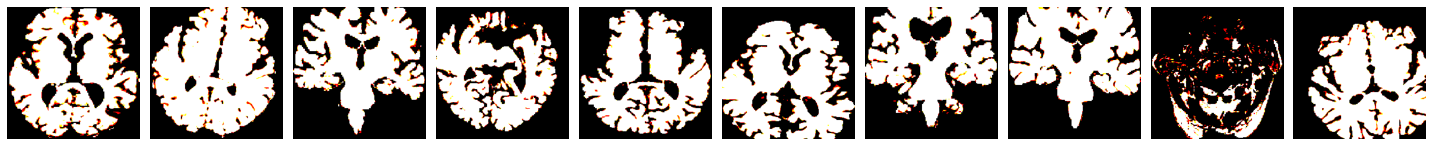

[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [13]:
plotImages(imgs)
print(labels)

## Construccion y entrenamiento del modelo CNN - VGG16

In [14]:
def conv_model(device_name):
    with tensorflow.device(device_name):
        model = Sequential()
        model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)))
        model.add(MaxPool2D(pool_size=(2,2), strides=2))
        model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
        model.add( MaxPool2D(pool_size=(2,2), strides=2))
        model.add(Flatten())      
        model.add(Dense(units=3, activation='softmax'))
        
        model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
        return model

 ## Entrenamiento del modelo VGG16

In [15]:
def run(model_arg):
    model_arg.fit(x=train_batches,
              validation_data=valid_batches,
              epochs=10,
              verbose=2)    
    return model_arg

In [16]:
#cpu_model = conv_model('CPU')
gpu_model = conv_model('DML')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
#cpu_model.summary()
gpu_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 602115    
Total params: 621,507
Trainable params: 621,507
Non-trainable params: 0
__________________________________________________

In [18]:
#cpu_model = conv_model('CPU')
gpu_model = conv_model('DML')

currentime_ini = datetime.datetime.now()
time = currentime_ini.strftime("%Y-%m-%d %H:%M:%S")
print("Procesando entrenamiento del modelo..", time)

#conv_cpu_trained = run(cpu_model)
conv_gpu_trained = run(gpu_model)

currentime_fin = datetime.datetime.now()
time = currentime_fin.strftime("%Y-%m-%d %H:%M:%S")
diff = currentime_fin - currentime_ini
print("Estampa tiempo fin entrenamiento..", time)


#print('Tiempo de entrenamiento en CPU con 10 Epochs: {} segundos'.format(conv_cpu_time))
print('\n')
print('Tiempo de entrenamiento en GPU con 10 Epochs: {} segundos'.format(diff))

Procesando entrenamiento del modelo.. 2022-06-20 16:44:56
Epoch 1/10
Epoch 1/10
535/535 - 113s - loss: 7.4469 - acc: 0.4527 - val_loss: 1.3431 - val_acc: 0.4292
Epoch 2/10
Epoch 1/10
535/535 - 16s - loss: 0.5018 - acc: 0.7997 - val_loss: 1.4544 - val_acc: 0.4300
Epoch 3/10
Epoch 1/10
535/535 - 16s - loss: 0.0927 - acc: 0.9800 - val_loss: 1.7299 - val_acc: 0.4601
Epoch 4/10
Epoch 1/10
535/535 - 17s - loss: 0.0199 - acc: 0.9994 - val_loss: 1.9562 - val_acc: 0.4530
Epoch 5/10
Epoch 1/10
535/535 - 16s - loss: 0.0055 - acc: 1.0000 - val_loss: 2.1147 - val_acc: 0.4617
Epoch 6/10
Epoch 1/10
535/535 - 16s - loss: 0.0025 - acc: 1.0000 - val_loss: 2.2352 - val_acc: 0.4727
Epoch 7/10
Epoch 1/10
535/535 - 16s - loss: 0.0015 - acc: 1.0000 - val_loss: 2.3630 - val_acc: 0.4680
Epoch 8/10
Epoch 1/10
535/535 - 16s - loss: 9.8812e-04 - acc: 1.0000 - val_loss: 2.4584 - val_acc: 0.4672
Epoch 9/10
Epoch 1/10
535/535 - 16s - loss: 6.8492e-04 - acc: 1.0000 - val_loss: 2.5625 - val_acc: 0.4672
Epoch 10/10
Epo

La exactitud o accuracy en el cliclo (epoch) 6 al 10 fue de 100% 
y la validacion de exactitud (val_acc) tomo valores entre: 43.26% y 43.03% lo que nos indica que no es tan buena

 ## Predicción con conjunto de pruebas

In [25]:
model = conv_gpu_trained
predictions = gpu_model.predict(x = test_batches, 
                                verbose = 0)

In [26]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [27]:
cm = confusion_matrix(y_true = test_batches.classes, 
                      y_pred = np.argmax(predictions, axis=-1))

In [28]:
test_batches.class_indices

{'AD': 0, 'CN': 1, 'MCI': 2}

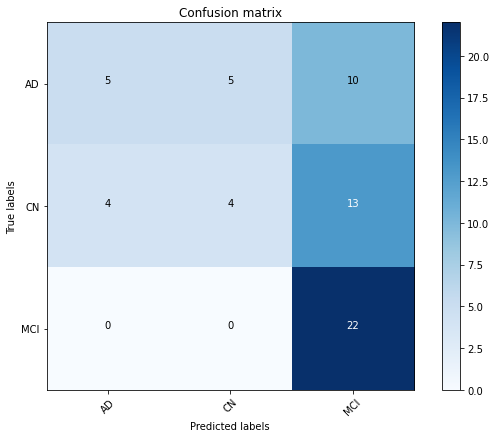

In [60]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
    
# a tuple for all the class names
target_names = ('AD', 'CN', 'MCI')
plot_confusion_matrix(cm, target_names)

## Visualizar resultados del entrenamiento

In [30]:
print(model.history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [31]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.4527419, 0.79973793, 0.9799738, 0.9994385, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.42924902, 0.43003953, 0.46007904, 0.45296443, 0.46166006, 0.47272727, 0.46798417, 0.46719366, 0.46719366, 0.46719366]
[7.455327271015127, 0.5024207990317449, 0.0926949118826857, 0.019925874182288576, 0.005520403375531889, 0.0025059574453565256, 0.00149191665947636, 0.000987427657039656, 0.0006856262695901042, 0.0004841253360352834]
[1.3430679285620142, 1.454374096290333, 1.7299369526660349, 1.95620735517637, 2.114734034134647, 2.2352114340921085, 2.3630168308892587, 2.458417673514584, 2.5625060041119734, 2.6538534575090633]


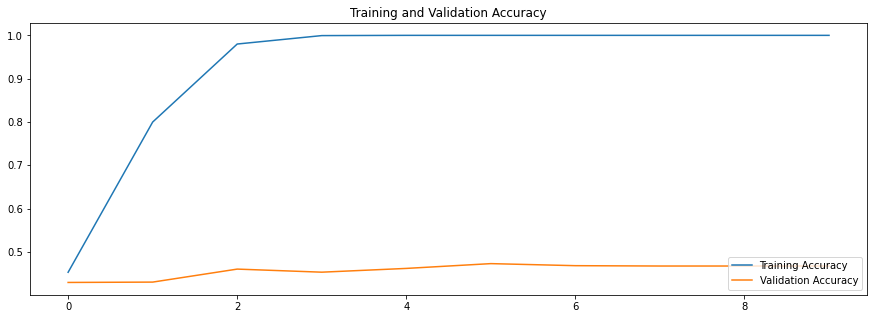

In [33]:
epochs_ft = 10
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(epochs_ft)

plt.figure(figsize=(15, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

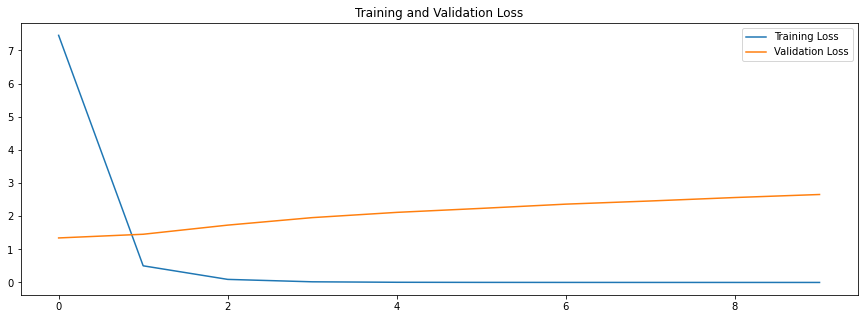

In [34]:
plt.figure(figsize=(15, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
y_true = test_batches.classes
y_pred = np.argmax(predictions, axis=-1)
target_names = ('AD', 'CN', 'MCI')

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          AD       0.36      0.25      0.29        20
          CN       0.37      0.33      0.35        21
         MCI       0.53      0.73      0.62        22

    accuracy                           0.44        63
   macro avg       0.42      0.44      0.42        63
weighted avg       0.42      0.44      0.42        63



---
---
---

## Construccion y construir afinar el modelo CNN-VGG16 (Modelo afinado)

In [42]:
# Agregar la base de la parte superior del modelo (top)

nb_classes = 3

def add_top(base):
    x = base.output

    # Capa de grupo de promedio global
    #x = GlobalAveragePooling2D()(x)

    x = tensorflow.keras.layers.Dense(64, activation='relu')(x)
    x = tensorflow.keras.layers.Dropout(0.2)(x)
    
    # Capa regular densamente conectada
    x = Dense(512, activation='relu')(x)

    # Capa de salida
    predictions = Dense(nb_classes, activation='softmax')(x)

    return Model(inputs = base.input, outputs= predictions)

In [43]:
# Modelo de configuración afinado
def setup_model(model, trainable):
    # Congelar las capas no entrenables de la base del modelo
    for layer in model.layers[:(len(model.layers) - trainable)]:
        layer.trainable = False

    for layer in model.layers[(len(model.layers) - trainable):]:
        layer.trainable = True

    model.compile(
        loss='categorical_crossentropy',
        # Tasa de entrenamiento más lenta para el ajuste fino
        optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
        # optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    
    return model

In [46]:
# Configurar el modelo para volver a entrenar nuestra 
# capa superior más el bloque 13 y 14 de Xception
with tensorflow.device('DML'):
    IMG_SHAPE = (224, 224, 3)
    ngg16_model = tensorflow.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE, 
                                                         include_top=False,
                                                         weights='imagenet',
                                                         pooling='avg')

    model = add_top(ngg16_model)
    model = setup_model(model, 19)

In [47]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [48]:
# Afinar la modelo

epochs_ft = 20

with tensorflow.device('DML'):
    earlystopper = EarlyStopping(monitor='val_loss',
                             min_delta=0, 
                             patience=10, # maximo epochs
                             verbose=1,
                             restore_best_weights=True,
                             mode='auto')
    
    model.fit_generator(train_batches,
                        epochs=epochs_ft,
                        validation_data=valid_batches,
                        verbose=2,
                        callbacks = [earlystopper])

Epoch 1/20
Epoch 1/20
535/535 - 180s - loss: 1.0965 - acc: 0.3981 - val_loss: 1.1629 - val_acc: 0.3976
Epoch 2/20
Epoch 1/20
535/535 - 180s - loss: 0.9723 - acc: 0.5227 - val_loss: 0.9771 - val_acc: 0.5162
Epoch 3/20
Epoch 1/20
535/535 - 180s - loss: 0.8909 - acc: 0.5635 - val_loss: 0.9381 - val_acc: 0.5233
Epoch 4/20
Epoch 1/20
535/535 - 180s - loss: 0.8209 - acc: 0.6051 - val_loss: 0.9954 - val_acc: 0.4964
Epoch 5/20
Epoch 1/20
535/535 - 180s - loss: 0.7482 - acc: 0.6487 - val_loss: 1.0282 - val_acc: 0.4893
Epoch 6/20
Epoch 1/20
535/535 - 180s - loss: 0.6750 - acc: 0.6990 - val_loss: 1.1697 - val_acc: 0.4972
Epoch 7/20
Epoch 1/20
535/535 - 180s - loss: 0.5734 - acc: 0.7552 - val_loss: 1.0222 - val_acc: 0.5099
Epoch 8/20
Epoch 1/20
535/535 - 180s - loss: 0.4911 - acc: 0.7952 - val_loss: 1.0900 - val_acc: 0.4980
Epoch 9/20
Epoch 1/20
535/535 - 180s - loss: 0.3862 - acc: 0.8465 - val_loss: 1.3385 - val_acc: 0.5075
Epoch 10/20
Epoch 1/20
535/535 - 180s - loss: 0.3235 - acc: 0.8722 - val_

## Predicción modelo afinado VGG16 (Modelo afinado)

In [54]:
predictions = model.predict(x=test_batches, verbose=0)

In [58]:
cm = confusion_matrix(y_true = test_batches.classes, 
                      y_pred = np.argmax(predictions, axis=-1))

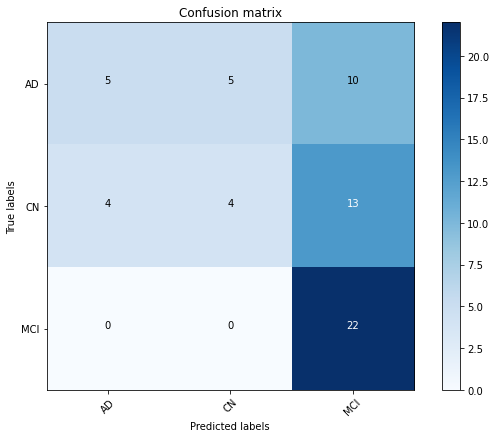

In [61]:
target_names = ('AD', 'CN', 'MCI')
plot_confusion_matrix(cm, target_names)

## Visualizar resultados del entrenamiento (Modelo afinado)

In [62]:
print(model.history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [63]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.39809096, 0.52274, 0.56354105, 0.60509074, 0.6486992, 0.6990455, 0.7551937, 0.7952461, 0.8465282, 0.8721692, 0.90660673, 0.9350552, 0.9460977]
[0.39762846, 0.51620555, 0.52332014, 0.49644268, 0.48932806, 0.49723318, 0.50988144, 0.49802372, 0.5075099, 0.52332014, 0.54624504, 0.5193676, 0.4869565]
[1.0965937847237048, 0.9726031066749775, 0.8902378633922347, 0.8206548988428675, 0.7486032401602879, 0.6753492212833234, 0.5729471549723627, 0.49099005000735857, 0.3856652665401518, 0.32208006591686883, 0.24532527561523837, 0.17793361308921535, 0.15159503206073466]
[1.1629308612327875, 0.9770881383437809, 0.9380565553199588, 0.9953839436290771, 1.028170092134025, 1.1696647217893226, 1.0222452627861593, 1.0900051619593554, 1.338549479959518, 1.5970468173815509, 1.5504967171376145, 1.6707465536012425, 2.267374331439574]


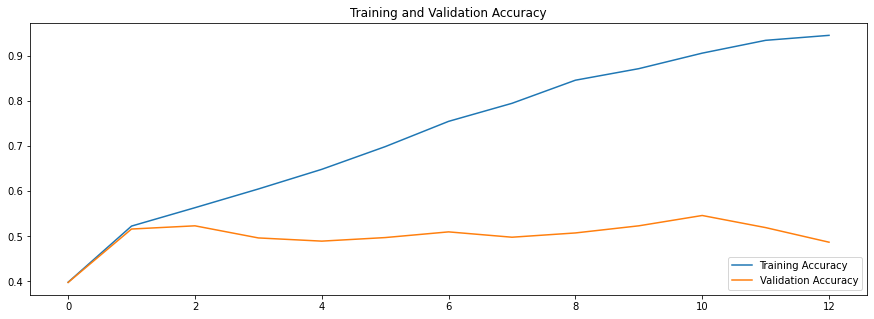

In [66]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(13)

plt.figure(figsize=(15, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

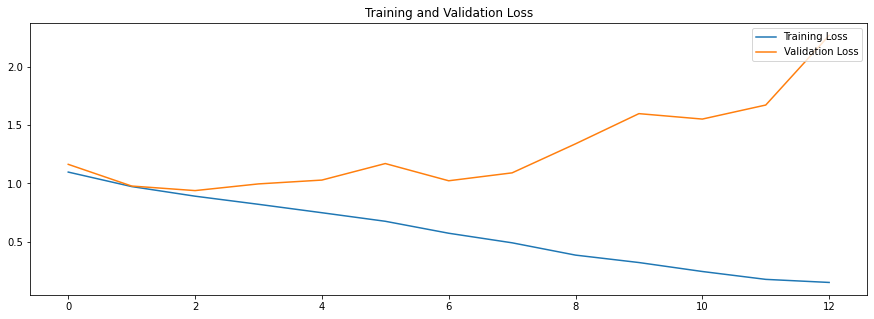

In [67]:
plt.figure(figsize=(15, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [68]:
y_true = test_batches.classes
y_pred = np.argmax(predictions, axis=-1)
target_names = ('AD', 'CN', 'MCI')

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          AD       0.56      0.25      0.34        20
          CN       0.44      0.19      0.27        21
         MCI       0.49      1.00      0.66        22

    accuracy                           0.49        63
   macro avg       0.50      0.48      0.42        63
weighted avg       0.50      0.49      0.43        63



# Referencias bibliográficas

In [ ]:
https://www.youtube.com/watch?v=q-HkgmJ4aR8&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=7

In [ ]:
https://neurohive.io/en/popular-networks/vgg16/

In [ ]:
https://www.youtube.com/watch?v=q-HkgmJ4aR8&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=7

In [ ]:
https://neurohive.io/en/popular-networks/vgg16/

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

https://colab.research.google.com/github/tfindiamooc/tfindiamooc.github.io/blob/master/colabs/image_classification_and_visualization.ipynb#scrollTo=1Ba2LjtkVrXy

https://learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

https://towardsdatascience.com/alzheimer-diagnosis-with-deep-learning-a-survey-265406fa542a

https://www.youtube.com/watch?v=3V9YFPfgyAY

In [ ]:
https://github.com/Yale-Deep-Learning-for-Alzheimers/Alzheimers-DL-Network

In [ ]:
https://www.kaggle.com/code/muneebkhurram/alzheimer-mri-classification

0. Image Preparation for Convolutional Neural Networks with TensorFlow's Keras API
https://www.youtube.com/watch?v=_L2uYfVV48I&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=10

0.1 Data Augmentation with TensorFlow's Keras API
https://www.youtube.com/watch?v=WSvpLUietIM&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=14

1.Keras with TensorFlow - Data Processing for Neural Network Training
https://www.youtube.com/watch?v=3FwGDUD_ZuQ&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=3

2.Build and Train a Convolutional Neural Network with TensorFlow's Keras API
https://www.youtube.com/watch?v=3V9YFPfgyAY&t=326s

3.Keras with TensorFlow Prerequisites - Getting Started With Neural Networks
https://www.youtube.com/watch?v=e47ISlpYFok

4.Train a Fine-Tuned Neural Network with TensorFlow's Keras API
https://www.youtube.com/watch?v=TguZ0WK0orQ

5.Create a Confusion Matrix for Neural Network Predictions
https://www.youtube.com/watch?v=VYGVOwlT4oE&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=9

6.MobileNet Image Classification with TensorFlow's Keras API
https://www.youtube.com/watch?v=5JAZiue-fzY&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=19

7.Save and Load a Model with TensorFlow's Keras API
https://www.youtube.com/watch?v=8Nl-of5C3uA&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=10

https://keras.io/api/applications/

https://note.nkmk.me/python-tensorflow-keras-applications-pretrained-models/

0. Image Preparation for Convolutional Neural Networks with TensorFlow's Keras API
https://www.youtube.com/watch?v=_L2uYfVV48I&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=10

0.1 Data Augmentation with TensorFlow's Keras API
https://www.youtube.com/watch?v=WSvpLUietIM&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=14

1.Keras with TensorFlow - Data Processing for Neural Network Training
https://www.youtube.com/watch?v=3FwGDUD_ZuQ&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=3

2.Build and Train a Convolutional Neural Network with TensorFlow's Keras API
https://www.youtube.com/watch?v=3V9YFPfgyAY&t=326s

3.Keras with TensorFlow Prerequisites - Getting Started With Neural Networks
https://www.youtube.com/watch?v=e47ISlpYFok

4.Train a Fine-Tuned Neural Network with TensorFlow's Keras API
https://www.youtube.com/watch?v=TguZ0WK0orQ

5.Create a Confusion Matrix for Neural Network Predictions
https://www.youtube.com/watch?v=VYGVOwlT4oE&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=9

6.MobileNet Image Classification with TensorFlow's Keras API
https://www.youtube.com/watch?v=5JAZiue-fzY&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=19

7.Save and Load a Model with TensorFlow's Keras API
https://www.youtube.com/watch?v=8Nl-of5C3uA&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=10